_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: FILL IN YOUR NAMES HERE

# Coding Lab 7 : Transcriptomics



In [1]:
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt


# We recommend using openTSNE for experiments with t-SNE
# https://github.com/pavlin-policar/openTSNE
from openTSNE import TSNE



%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2023-06-18 15:24:10W. Europe Daylight Time

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.12.0

sklearn: 1.2.2

numpy     : 1.24.3
matplotlib: 3.7.1
pandas    : 1.5.3

Watermark: 2.3.1



In [2]:
plt.style.use("../matplotlib_style.txt")

## Load data

Download the data from ILIAS, move it to the `data` directory and unzip it there.

In [3]:
# LOAD HARRIS ET AL DATA

# Load gene counts
data = pd.read_csv("../data/nds_cl_7/harris-data/expression.tsv.gz", sep="\t")
genes = data.values[:, 0]
cells = data.columns[1:-1]
counts = data.values[:, 1:-1].transpose().astype("int")
data = []

# Kick out all genes with all counts = 0
genes = genes[counts.sum(axis=0) > 0]
counts = counts[:, counts.sum(axis=0) > 0]
print(counts.shape)

# Load clustering results
data = pd.read_csv("../data/nds_cl_7/harris-data/analysis_results.tsv", sep="\t")
clusterNames, clusters = np.unique(data.values[0, 1:-1], return_inverse=True)

# Load cluster colors
data = pd.read_csv("../data/nds_cl_7/harris-data/colormap.txt", sep="\s+", header=None)
clusterColors = data.values

# Note: the color order needs to be reversed to match the publication
clusterColors = clusterColors[::-1]

# Taken from Figure 1 - we need cluster order to get correct color order
clusterOrder = [
    "Sst.No",
    "Sst.Npy.C",
    "Sst.Npy.Z",
    "Sst.Npy.S",
    "Sst.Npy.M",
    "Sst.Pnoc.Calb1.I",
    "Sst.Pnoc.Calb1.P",
    "Sst.Pnoc.P",
    "Sst.Erbb4.R",
    "Sst.Erbb4.C",
    "Sst.Erbb4.T",
    "Pvalb.Tac1.N",
    "Pvalb.Tac1.Ss",
    "Pvalb.Tac1.Sy",
    "Pvalb.Tac1.A",
    "Pvalb.C1ql1.P",
    "Pvalb.C1ql1.C",
    "Pvalb.C1ql1.N",
    "Cacna2d1.Lhx6.R",
    "Cacna2d1.Lhx6.V",
    "Cacna2d1.Ndnf.N",
    "Cacna2d1.Ndnf.R",
    "Cacna2d1.Ndnf.C",
    "Calb2.Cry",
    "Sst.Cry",
    "Ntng1.S",
    "Ntng1.R",
    "Ntng1.C",
    "Cck.Sema",
    "Cck.Lmo1.N",
    "Cck.Calca",
    "Cck.Lmo1.Vip.F",
    "Cck.Lmo1.Vip.C",
    "Cck.Lmo1.Vip.T",
    "Cck.Ly",
    "Cck.Cxcl14.Calb1.Tn",
    "Cck.Cxcl14.Calb1.I",
    "Cck.Cxcl14.S",
    "Cck.Cxcl14.Calb1.K",
    "Cck.Cxcl14.Calb1.Ta",
    "Cck.Cxcl14.V",
    "Vip.Crh.P",
    "Vip.Crh.C1",
    "Calb2.Vip.G",
    "Calb2.Vip.I",
    "Calb2.Vip.Nos1",
    "Calb2.Cntnap5a.R",
    "Calb2.Cntnap5a.V",
    "Calb2.Cntnap5a.I",
]

reorder = np.zeros(clusterNames.size) * np.nan
for i, c in enumerate(clusterNames):
    for j, k in enumerate(clusterOrder):
        if c[: len(k)] == k:
            reorder[i] = j
            break
clusterColors = clusterColors[reorder.astype(int)]

(3663, 17965)


## 1. Data inspection
Before we use t-SNE or any other advanced visualization methods on the data, we first want to have a closer look on the data and plot some statistics. For most of the analysis we will compare the data to a Poisson distribution.

###  1.1. Relationship between expression mean and fraction of zeros
The higher the average expression of a gene, the smaller fraction of cells will show a 0 count. 


_(2pt.)_

In [5]:
genes.shape, counts.shape, cells.shape

((17965,), (3663, 17965), (3663,))

In [13]:
print("Cells", cells[0:10])
print("Genes", genes[0:10])
print("Count of genes for each cell", counts[0:10, 0:10])

Cells Index(['Kevontae', 'Krishav', 'Zinachidi', 'Eliott', 'Fitzgerald', 'Kamaria',
       'Hatch', 'Nana', 'Bindi', 'Avalyn'],
      dtype='object')
Genes ['Xkr4' 'Gm1992' 'Sox17' 'Mrpl15' 'Lypla1' 'Gm37988' 'Tcea1' 'Rgs20'
 'Atp6v1h' 'Oprk1']
Count of genes for each cell [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [25]:
cell_gene = pd.DataFrame(data=counts, columns=genes, index=cells)
print(
    "Ceels are rows and genes are columns and each correpsonding value is the count of that gene in that cell"
)
cell_gene

Ceels are rows and genes are columns and each correpsonding value is the count of that gene in that cell


,Xkr4,Gm1992,Sox17,Mrpl15,Lypla1,Gm37988,Tcea1,Rgs20,Atp6v1h,Oprk1,...,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,Vamp7,Spry3,Tmlhe,PISD,DHRSX,CAAA01147332.1
Kevontae,0,0,0,0,0,0,0,0,0,0,...,0,2,0,1,0,0,0,0,0,0
Krishav,0,0,0,0,0,0,0,0,0,0,...,4,0,0,4,0,0,0,2,0,0
Zinachidi,0,0,0,0,0,0,0,0,0,0,...,6,1,0,12,0,0,0,1,0,0
Eliott,0,0,0,0,0,0,0,0,0,0,...,3,1,0,6,0,0,0,0,0,0
Fitzgerald,0,0,0,0,0,0,0,0,0,0,...,2,0,0,5,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Makensey,0,0,0,0,0,0,0,1,0,1,...,34,6,0,43,0,0,0,0,0,0
Marzia,0,0,0,0,1,0,0,0,1,0,...,30,8,0,50,0,0,0,0,0,0
Tulip,0,0,0,1,0,0,0,0,0,0,...,45,8,0,59,1,0,0,0,0,0
Ladale,0,0,0,0,0,0,0,0,0,0,...,35,7,0,57,1,0,0,2,1,0


In [94]:
# ------------------------------------------------------
# Compute actual and predicted gene expression (1.5 pts)
# ------------------------------------------------------

# Compute the average expression for each gene
# avg_gene_exp = np.mean(counts, axis=0)
average_expression = cell_gene.mean(axis=0)


# Compute the fraction of zeros for each gene
fraction_zeros = (cell_gene == 0).astype(int).sum(axis=0) / cell_gene.shape[0]

In [95]:
average_expression.shape, fraction_zeros.shape

((17965,), (17965,))

In [96]:
# Compute the Poisson prediction

# Probability mass function of Poisson distribution at zero => pmf_k = np.exp(-lambda) * (lambda ** k) / np.math.factorial(k) and here k=0
poisson_prediction = np.exp(-average_expression)

# (what is the expected fraction of zeros in a Poisson distribution with a given mean?)

C:\Users\nitin\AppData\Local\Temp\ipykernel_23372\18714519.py:44: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.2)


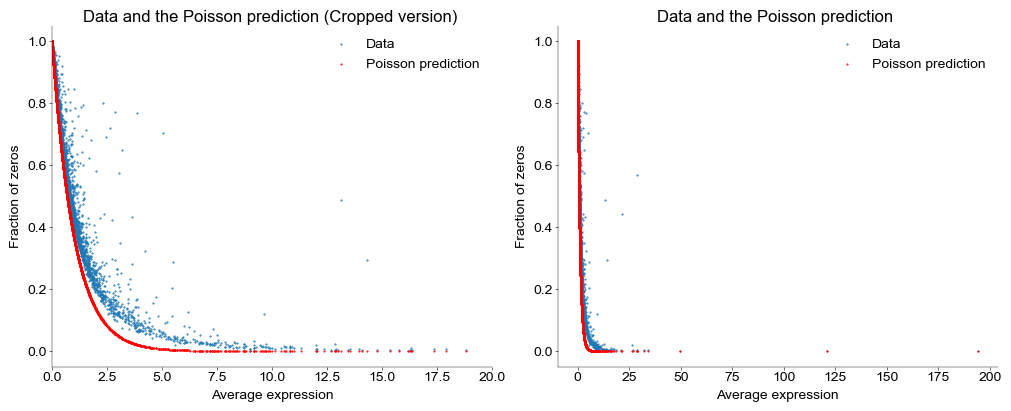

In [180]:
# --------------------------------------------------
# plot the data and the Poisson prediction (0.5 pts)
# --------------------------------------------------

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# add plot

# Scatter plot of fraction of zeros vs average expression
ax = axs[0]
ax.scatter(average_expression, fraction_zeros, label="Data", s=1)
# Line plot of Poisson prediction vs average expression
ax.scatter(
    average_expression,
    poisson_prediction,
    color="red",
    label="Poisson prediction",
    s=1,
)
# Add labels and legend
ax.set_xlim([0, 20])
ax.set_xlabel("Average expression")
ax.set_ylabel("Fraction of zeros")
ax.set_title("Data and the Poisson prediction (Cropped version) ")
ax.legend()


ax = axs[1]
ax.scatter(average_expression, fraction_zeros, label="Data", s=1)
# Line plot of Poisson prediction vs average expression
ax.scatter(
    average_expression,
    poisson_prediction,
    color="red",
    label="Poisson prediction",
    s=1,
)
# Add labels and legend
# ax.set_xlim([0, 25])
ax.set_xlabel("Average expression")
ax.set_ylabel("Fraction of zeros")
ax.set_title("Data and the Poisson prediction ")
ax.legend()

fig.subplots_adjust(wspace=0.2)

### 1.2. Mean-variance relationship

If the expression follows Poisson distribution, then the mean should be equal to the variance.

_(1pt.)_

In [101]:
# Compute the variance of the expression counts of each gene
var_expression = cell_gene.var(axis=0)

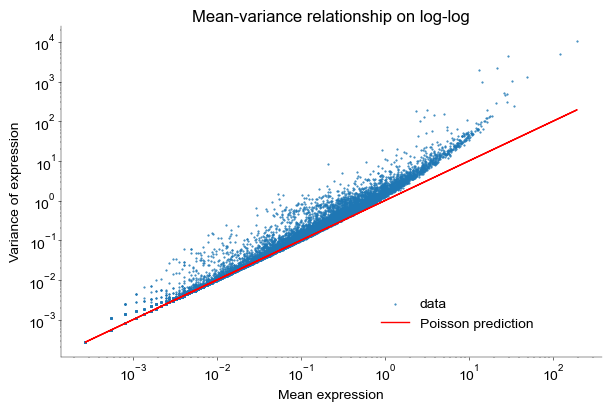

In [115]:
# Plot the mean-variance relationship on a log-log plot
# Plot the Poisson prediction as a line

fig, ax = plt.subplots(figsize=(6, 4))

# ----------------------------
# plot variance vs mean (1 pt)
# incl. computing mean and var
# ----------------------------

ax.scatter(average_expression, var_expression, label="data", s=1)
ax.plot(
    average_expression, average_expression, color="red", label="Poisson prediction"
)  # For poisson, mean = vairance
ax.loglog()
# Add labels
ax.set_xlabel("Mean expression")
ax.set_ylabel("Variance of expression")
ax.set_title("Mean-variance relationship on log-log")
fig.legend(bbox_to_anchor=[0.9, 0.3])

### 1.3. Relationship between the mean and the Fano factor

If the expression follows the Poisson distribution, then the Fano factor (variance/mean) should be equal to 1 for all genes.

_(1pt.)_

In [118]:
# Compute the Fano factor for each gene and make a scatter plot
# of expression mean vs. Fano factor in log-log coordinates.

# Fano factor = variance/mean
fano = var_expression / average_expression

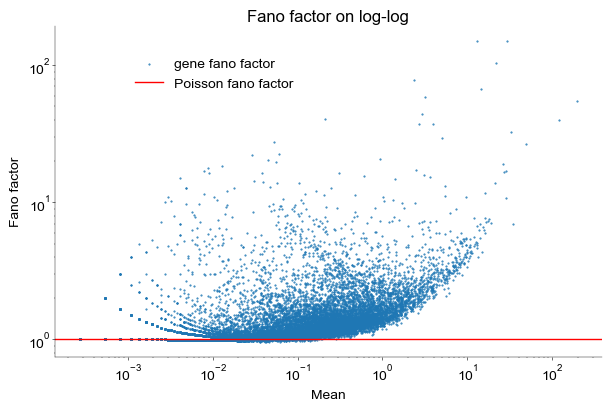

In [130]:
# Plot a Poisson prediction as line
# Use the same style of plot as above.

fig, ax = plt.subplots(figsize=(6, 4))

# -------------------------------
# plot fano-factor vs mean (1 pt)
# incl. fano factor
# -------------------------------

ax.scatter(average_expression, fano, label="gene fano factor", s=1)
ax.axhline(y=1, color="red", label="Poisson fano factor")
ax.loglog()
# Add labels
ax.set_xlabel("Mean")
ax.set_ylabel("Fano factor")
ax.set_title("Fano factor on log-log")
fig.legend(bbox_to_anchor=[0.5, 0.9])
plt.show()

### 1.4. Histogram of sequencing depths

Different cells have different sequencing depths (sum of counts across all genes) because the efficiency can change from droplet to droplet due to some random expreimental factors.

_(1pt.)_

Text(0.5, 1.0, 'Histogram of sequencing depths across cells')

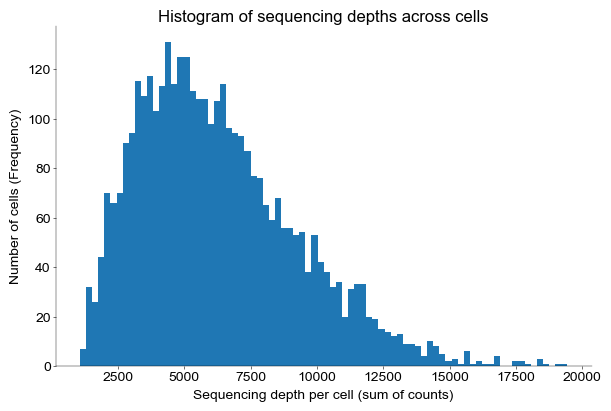

In [143]:
# Make a histogram of sequencing depths across cells.
# Sequencing depth of each cell is the sum of all counts of this cell

fig, ax = plt.subplots(figsize=(6, 4))

# ------------------------------------------
# Plot histogram of sequencing depths (1 pt)
# ------------------------------------------

sequencing_depths = cell_gene.sum(axis=1)

ax.hist(sequencing_depths, bins=80)
ax.set_xlabel("Sequencing depth per cell (sum of counts)")
ax.set_ylabel("Number of cells (Frequency)")
ax.set_title("Histogram of sequencing depths across cells")

### 1.5. Fano factors after normalization

After normalization by sequencing depth, Fano factor should be closer to 1 (i.e. variance even more closely following the mean). This can be used for feature selection.

_(1pt.)_

In [153]:
# Normalize counts by the sequencing depth of each cell and multiply by the median sequencing depth
# Then make the same expression vs Fano factor plot as above

# -----------------------------------
# compute normalized counts (0.5 pts)
# -----------------------------------

normalized_counts = cell_gene.div(sequencing_depths, axis=0)
normalized_counts = normalized_counts * sequencing_depths.median()

fano_norm = normalized_counts.var(axis=0) / normalized_counts.mean(axis=0)

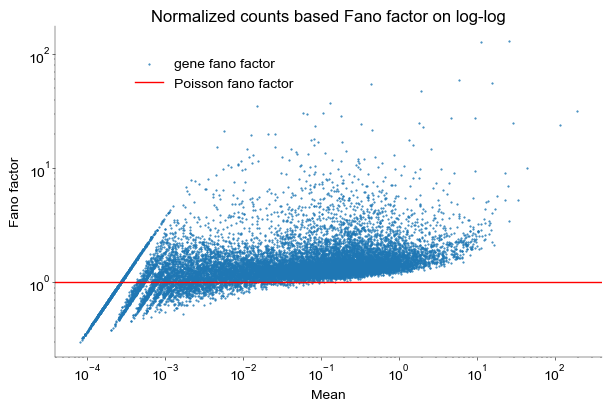

In [157]:
# ----------------------------------------------------------
# plot normalized counts and find the top 10 genes (0.5 pts)
# hint: keep appropriate axis scaling in mind
# ----------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
# add plot

ax.scatter(normalized_counts.mean(axis=0), fano_norm, label="gene fano factor", s=1)
ax.axhline(y=1, color="red", label="Poisson fano factor")
ax.loglog()
# Add labels
ax.set_xlabel("Mean")
ax.set_ylabel("Fano factor")
ax.set_title("Normalized counts based Fano factor on log-log")
fig.legend(bbox_to_anchor=[0.5, 0.9])
plt.show()

In [170]:
# Find top-10 genes with the highest normalized Fano factor
# Print them sorted by the Fano factor starting from the highest
# Gene names are stored in the `genes` array
top_10_fano_norm = list(fano_norm.sort_values(ascending=False).iloc[0:10].index)
print("top-10 genes with the highest normalized Fano factor are as follows:")
print(np.array(top_10_fano_norm))

top-10 genes with the highest normalized Fano factor are as follows:
['Sst' 'Npy' 'Vip' 'Cck' 'Cpne2' 'Pcp4' 'Ptpn23' 'Pdzd9' 'Malat1' 'Armc2']


## 2. Low dimensional visualization

Here we look at the influence of variance-stabilizing transformations on PCA and t-SNE.

### 2.1. PCA with and without transformations

Square root is a variance-stabilizing transformation for the Poisson data. Log-transform is also often used in the transcriptomic community. Look at the effect of both.

_(1pt.)_

In [15]:
# --------------------------------------
# transform data and apply PCA (0.5 pts)
# --------------------------------------

# Transform the counts into normalized counts (as above)
# Select all genes with the normalized Fano factor above 3 and remove the rest

In [16]:
# Perform PCA three times: on the resulting matrix as is,
# after np.log2(X+1) transform, and after np.sqrt(X) transform

from sklearn.decomposition import PCA
# perform PCA

In [ ]:
# -------------------------------------------
# plot first 2 PCs for each dataset (0.5 pts)
# -------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot

### 2.2. tSNE with and without transformations

Do these transformations have any effect on t-SNE?

_(1pt.)_

In [18]:
# -----------------------------------------------------------------------
# Perform tSNE three times: on the resulting matrix as is,
# after np.log2(X+1) transform, and after np.sqrt(X) transform. (0.5 pts)
# -----------------------------------------------------------------------

# Apply t-SNE to the 50 PCs

# Use default settings of openTSNE
# You can also use sklearn if you want

(-67.52920428861165, 68.45317921108641, -61.5705516418754, 72.22259231348454)

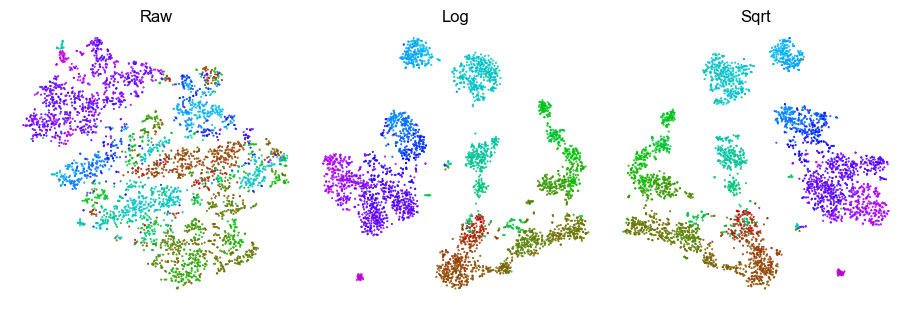

In [19]:
# -----------------------------------------------
# plot t-SNE embedding for each dataset (0.5 pts)
# -----------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot

### 2.3. Leiden clustering

This dataset is small and can be clustered in many different ways. We will apply Leiden clustering (closely related to the Louvain clustering), which is standard in the field and works well even for very large datasets.

_(1pt.)_

In [20]:
# To run this code you need to install leidenalg and igraph
# conda install -c conda-forge python-igraph leidenalg

import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import leidenalg as la

In [21]:
# Define some contrast colors

clusterCols = [
    "#FFFF00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#FFDBE5",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#997D87",
    "#5A0007",
    "#809693",
    "#FEFFE6",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#61615A",
    "#BA0900",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#DDEFFF",
    "#000035",
    "#7B4F4B",
    "#A1C299",
    "#300018",
    "#0AA6D8",
    "#013349",
    "#00846F",
    "#372101",
    "#FFB500",
    "#C2FFED",
    "#A079BF",
    "#CC0744",
    "#C0B9B2",
    "#C2FF99",
    "#001E09",
    "#00489C",
    "#6F0062",
    "#0CBD66",
    "#EEC3FF",
    "#456D75",
    "#B77B68",
    "#7A87A1",
    "#788D66",
    "#885578",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#BEC459",
    "#456648",
    "#0086ED",
    "#886F4C",
    "#34362D",
    "#B4A8BD",
    "#00A6AA",
    "#452C2C",
    "#636375",
    "#A3C8C9",
    "#FF913F",
    "#938A81",
    "#575329",
    "#00FECF",
    "#B05B6F",
    "#8CD0FF",
    "#3B9700",
    "#04F757",
    "#C8A1A1",
    "#1E6E00",
    "#7900D7",
    "#A77500",
    "#6367A9",
    "#A05837",
    "#6B002C",
    "#772600",
    "#D790FF",
    "#9B9700",
    "#549E79",
    "#FFF69F",
    "#201625",
    "#72418F",
    "#BC23FF",
    "#99ADC0",
    "#3A2465",
    "#922329",
    "#5B4534",
    "#FDE8DC",
    "#404E55",
    "#0089A3",
    "#CB7E98",
    "#A4E804",
    "#324E72",
    "#6A3A4C",
    "#83AB58",
    "#001C1E",
    "#D1F7CE",
    "#004B28",
    "#C8D0F6",
    "#A3A489",
    "#806C66",
    "#222800",
    "#BF5650",
    "#E83000",
    "#66796D",
    "#DA007C",
    "#FF1A59",
    "#8ADBB4",
    "#1E0200",
    "#5B4E51",
    "#C895C5",
    "#320033",
    "#FF6832",
    "#66E1D3",
    "#CFCDAC",
    "#D0AC94",
    "#7ED379",
    "#012C58",
]

clusterCols = np.array(clusterCols)

# ------------------------------------------------------
# create graph and run leiden clustering on it (0.5 pts)
# hint: use `la?`, `la.find_partition?` and `ig.Graph?` 
# to find out more about the provided packages.
# ------------------------------------------------------

# Construct kNN graph with k=15
A = 
# Transform it into an igraph object
sources, targets = A.nonzero()

In [22]:
# Run Leiden clustering
# you can use `la.RBConfigurationVertexPartition` as the partition type

In [ ]:
# --------------------------
# Plot the results (0.5 pts)
# --------------------------

fig, ax = plt.subplots(figsize=(4, 4))

### 2.4. Change the clustering resolution

The number of clusters can be changed by modifying the resolution parameter.

_(1pt.)_

In [ ]:
# How many clusters did we get?
# Change the resolution parameter to yield 2x more and 2x fewer clusters
# Plot all three results as tSNE overlays (as above)

# ------------------------------------------------------------------
# run the clustering for 3 different resolution parameters (0.5 pts)
# ------------------------------------------------------------------

(-67.52920428861165, 68.45317921108641, -61.5705516418754, 72.22259231348454)

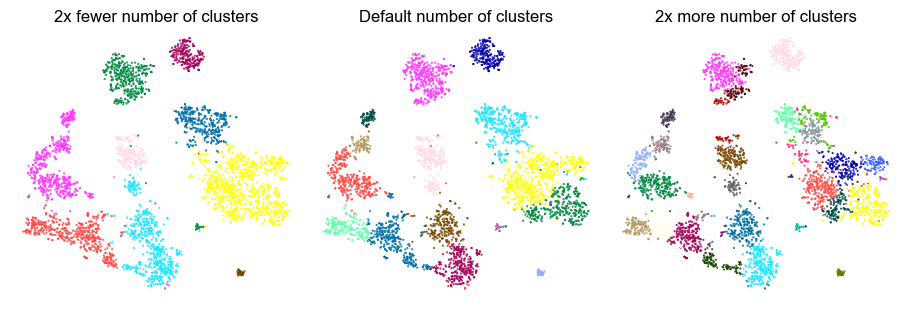

In [26]:
# --------------------------
# Plot the results (0.5 pts)
# --------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot